#Globals

In [71]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing",

    # Networks
    'hidden_dim' : 256,
    'print_debug' : False,
    'verts_dim' : 3,
    'emb_net_depth' : 4,
    'disp_dim' : 1,
    'disp_net_depth' : 2,
    'norm_ratio' : 0.1
}

In [2]:
!pip install gdown open3d --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00


In [3]:
!pip install kaolin -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.1.0_cu121.html

Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.1.0_cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.7/255.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.2 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.1-py3-none-any.whl size=27085 sha256=0c28c8a66b107c721e49a3c14328c7b6e8ced444dd29794cea1c91f328d5c836
  Stored in directory: /root/.cache/pip/wheels/9c/73/91/ae3a93bb6cc6dde662ed1dc48dd0ec7ca41a7bcc2a1a99b5a6
Successfully built pygltflib


In [4]:
!pip install Normalization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Normalization: filename=normalization-0.4-py3-none-any.whl size=43994 sha256=bf238924b91faf6205c142064bc27a2e295fc19543fd13f97f53b2317a994b38
  Stored in directory: /root/.cache/pip/wheels/ff/18/30/a64cda03dd70fece2924da118b1667c25421c30832e1530f3f
Successfully built Normalization


#Imports

In [40]:
import copy
import gdown
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import plotly.graph_objects as go
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import transforms
from tqdm import tqdm

import kaolin.ops.mesh
import kaolin as kal

In [6]:
if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
    # We try to install PyTorch3D via a released wheel.
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
else:
    # We try to install PyTorch3D from source.
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=5e149220afe2e27fcc9de550af4c6d205805e9d08260ad258c8450f33ce56d96
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=c54a231738fe12a6235dc4cedfb22d869573f75698352d6d3ab2ef3e9eafcf2d
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 51.5 MB/s eta 0:00:00


In [7]:
from pytorch3d.io import load_objs_as_meshes, load_obj # Util function for loading meshes
from pytorch3d.structures import Meshes # Data structures and functions for rendering
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

from pytorch3d.ops import knn_points

In [8]:
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Dataset

## Data download

In [9]:
if not os.path.exists(global_var['mesh_data_path']):
    print("[LOG] Starting dataset download...")
    gdown.download_folder(url = global_var['mesh_data_url'],
        output = global_var['mesh_data_path'],
        quiet=True)
    print("[LOG] Dataset download ended!")

else:
    print("[LOG] Mesh dataset already downloaded!")

[LOG] Starting dataset download...
[LOG] Dataset download ended!


## Shape visualization

In [10]:
def get_dataset_meshes(dataset_path):
    meshes_paths = []
    meshes = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)
                meshes.append(load_objs_as_meshes([mesh_path],device=device))

    return meshes_paths, meshes

In [11]:
def mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True)
            )
        )
    )

    return fig

In [12]:
meshes_paths, meshes = get_dataset_meshes(global_var['mesh_data_path'])
random_mesh_idx = random.randint(0,len(meshes_paths)-1)
random_mesh_path = meshes_paths[random_mesh_idx]
random_mesh = meshes[random_mesh_idx]

mesh_fig = mesh_visualization(random_mesh_path)
mesh_fig.show()

In [13]:
random_mesh_idx

3

## Rendered shape visualization

In [93]:
def rendered_shape(mesh, device, items=3):
    distances = [round(random.uniform(1, 3),2) for _ in range(items)] # Controllare valori default da cui selezionare quelli random
    elevations = [random.randint(0, 359) for _ in range(items)] # This is the angle between the vector from the object to the camera, and the horizontal plane y = 0 (xz-plane).
    angles = [random.randint(0, 359) for _ in range(items)] # The vector from the object to the camera is projected onto a horizontal plane y = 0. azim is the angle between the projected vector and a reference vector at (0, 0, 1) on the reference plane (the horizontal plane).
    rendered_images = []

    for idx in range(items):
        print(f"[LOG] Computing render for distance {distances[idx]}, elevation {elevations[idx]}, angle {angles[idx]}") if global_var['print_debug'] else None
        R, T = look_at_view_transform(
            distances[idx],
            elevations[idx],
            angles[idx],
            degrees=True)

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights
            )
        )

        rendered_images.append(renderer(mesh))

    return distances, elevations, angles, rendered_images

In [15]:
distances, elevations, angles, rendered_images = rendered_shape(random_mesh,device,items=4)

[LOG] Computing render for distance 2.12, elevation 125, angle 69
[LOG] Computing render for distance 1.03, elevation 265, angle 217
[LOG] Computing render for distance 2.21, elevation 313, angle 143
[LOG] Computing render for distance 1.69, elevation 147, angle 315


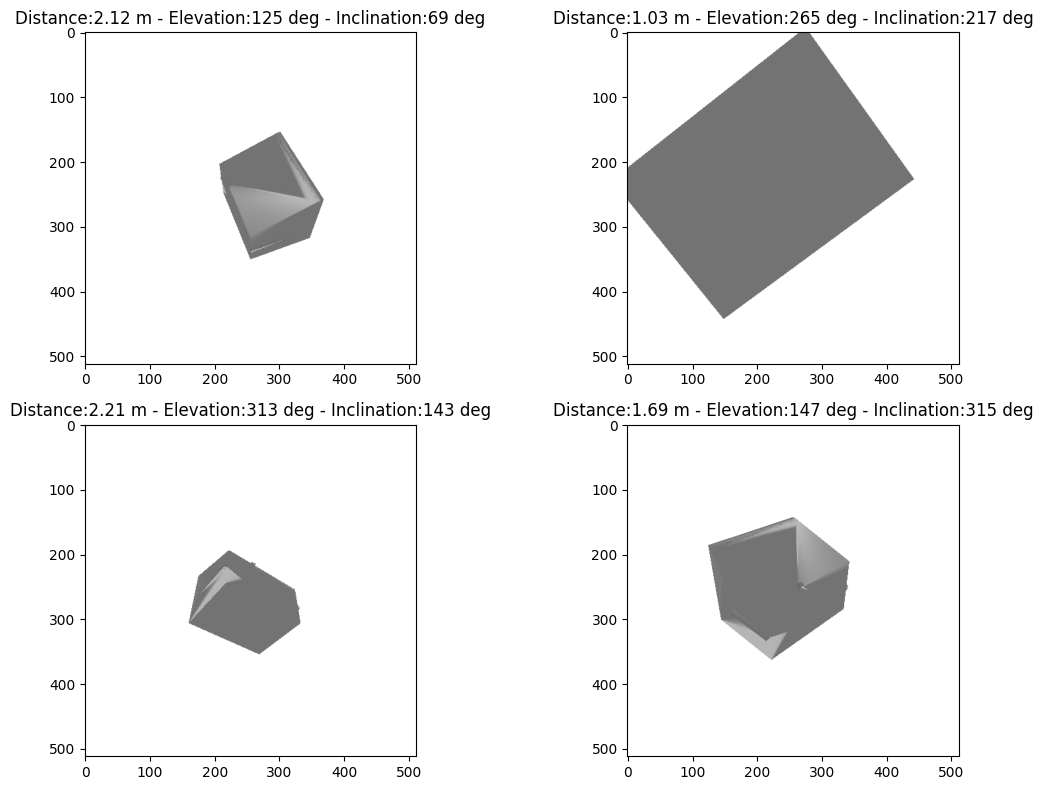

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances[i]} m - Elevation:{elevations[i]} deg - Inclination:{angles[i]} deg")

plt.tight_layout()
plt.show()

# Detailed architecture

## Input features
The workflow starts with extracting the vertices of the meshes related to the 3D shape we want to deform. These vertices will be the input to the neural network that will approximate the displacement vector for the deformation. From this point until the end of the workflow, a fixed 3D shape will be considered for the sake of clarity of the steps.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/082ad323538acf40a913a9de7478f81e8caff09f/pics/mesh_vers.png?token=GHSAT0AAAAAACKX5CENWWY3O7WUFMTECKI2ZMP6YTA" alt="Mesh_verts" />
</center>

In [17]:
def get_mesh(obj_path):
    verts, faces_idxs, _ = load_obj(obj_path)
    faces = faces_idxs.verts_idx

    # Initialize each vertex to be white in color since this feature isn't required in our project
    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
    )

    return mesh

In [18]:
sample_mesh_path = meshes_paths[0]
sample_mesh = get_mesh(sample_mesh_path)
sample_mesh_shape = sample_mesh.verts_list()[0].shape
vertices_num = sample_mesh_shape[0]
vertices_dim = sample_mesh_shape[1]
print(f"[LOG] 3D shape has {vertices_num} vertices with dimension {vertices_dim}")

mesh_fig = plot_scene({
    "Sample mesh": {
        "mesh": sample_mesh
    }
})
mesh_fig.show()

[LOG] 3D shape has 110 vertices with dimension 3


In [19]:
distances__, elevations__, angles__, rendered_images__ = rendered_shape(sample_mesh,device,items=4)

[LOG] Computing render for distance 2.69, elevation 304, angle 266
[LOG] Computing render for distance 2.27, elevation 117, angle 198
[LOG] Computing render for distance 1.86, elevation 36, angle 334
[LOG] Computing render for distance 2.0, elevation 240, angle 167


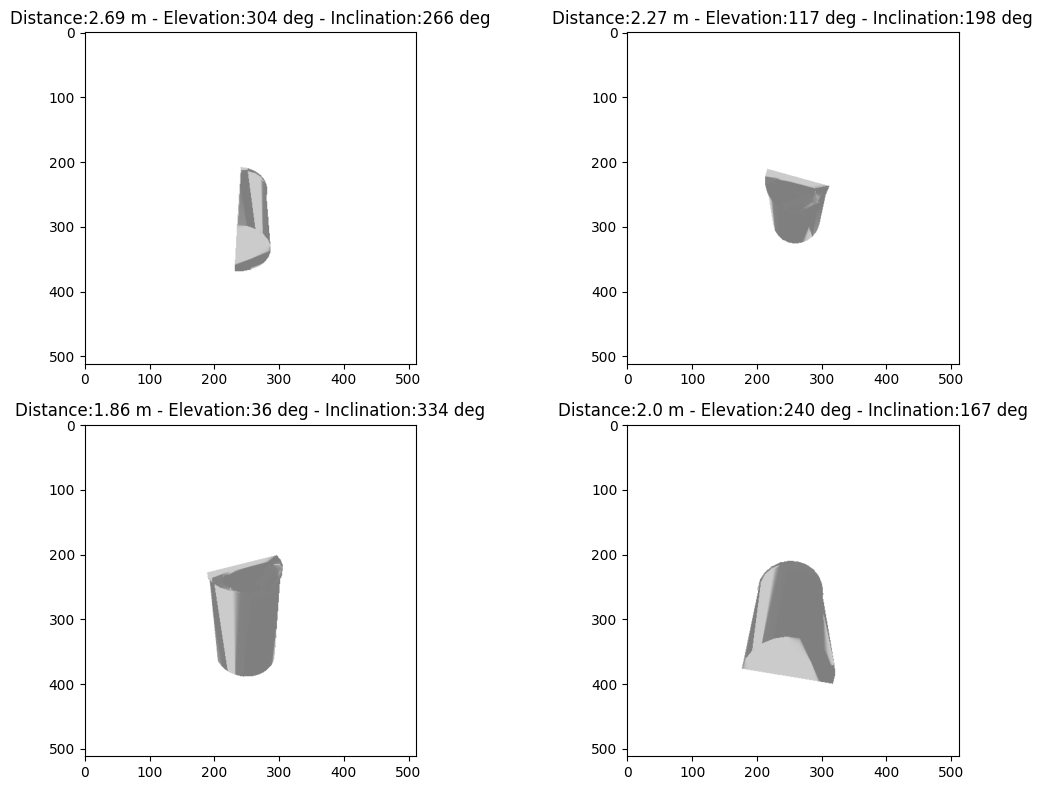

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images__[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances__[i]} m - Elevation:{elevations__[i]} deg - Inclination:{angles__[i]} deg")

plt.tight_layout()
plt.show()

## Positional encoding
Positional encoding is important in the context of mesh vertices of a 3D shape because the neural network treats vertices as tokens, without any information about their relative position in the mesh. Without some form of position information, the model may have difficulty capturing the spatial relationships between vertices, which are critical in 3D representations. This approach can be learned, simply by leveraging a fully connected layer. By doing so, the input vertices will be processed in such a way as to retain their spatial info.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/pos_encd.png?token=GHSAT0AAAAAACKX5CEMARWWJCXSJZMMKEMGZMP7NSQ" alt="Pos_enc" />
</center>

In [21]:
class PositionalEncodingNet(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, debug=False):
        super(PositionalEncodingNet, self).__init__()

        layers = []
        layers.append(nn.Linear(verts_dim,hidden_dim))
        layers.append(nn.ReLU())

        self.debug = debug
        self.pos_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Positional Encoding network")
            print(self.pos_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.pos_net:
            x = layer(x)

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [67]:
sample_mesh_verts = sample_mesh.verts_list()[0].requires_grad_(True)
sample_mesh_verts_shape = sample_mesh_verts.shape
print(f"[LOG] Mesh vertices are in a {type(sample_mesh_verts)} of shape {sample_mesh_verts_shape}")

pos_encoder = PositionalEncodingNet(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    debug = global_var['print_debug']).to(device)

positioned_mesh_verts = pos_encoder(sample_mesh_verts)

[LOG] Mesh vertices are in a <class 'torch.Tensor'> of shape torch.Size([110, 3])

[LOG] Positional Encoding network
ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
)

[LOG] ************* PositionalEncodingNet forward: START *************

[LOG] Input shape: torch.Size([110, 3])
[LOG] Output shape: torch.Size([110, 256])

[LOG] ************* PositionalEncodingNet forward: END *************


## Embedded vertices
After including the spatial info relative to the vertices of the mesh, the next step in the workflow sees a small neural network embedding the aforementioned element.

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/verts_emb.png?token=GHSAT0AAAAAACKX5CEMW43EYJJ2QPDLZGWAZMQAUPA" alt="Verts_emb" />
</center>

In [23]:
class EmbeddingNet(nn.Module):
    def __init__(self, hidden_dim=256, depth=4, debug=False):
        super(EmbeddingNet, self).__init__()

        layers = []
        for i in range(depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())


        self.debug = debug
        self.emb_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Embedding network")
            print(self.emb_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.emb_net:
            x = layer(x)

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [24]:
embed_net = EmbeddingNet(
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    debug = global_var['print_debug']).to(device)

embedded_mesh_verts = embed_net(positioned_mesh_verts)


[LOG] Embedding network
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
)

[LOG] ************* EmbeddingNet forward: START *************

[LOG] Input shape: torch.Size([110, 256])
[LOG] Output shape: torch.Size([110, 256])

[LOG] ************* EmbeddingNet forward: END *************


## Displacement prediction

The network's output is indicative of a displacement along the vertex normal. To mitigate any alterations to the content, strict control is exercised over the vertex normal, ensuring it remains confined within the specified range of $(-0.1, 0.1)$. This measure aims to preserve the original content by restricting the extent of vertex normal adjustments

<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/verts_disp.png?token=GHSAT0AAAAAACKX5CEMPMVC2BOZO4XJRXVWZMQEPXA" alt="Verts_disp" />
</center>

In [25]:
class DisplacementNet(nn.Module):
    def __init__(self, disp_dim=1, hidden_dim=256, disp_depth=2, norm_ratio = 0.1, debug=False):
        super(DisplacementNet, self).__init__()

        layers = []
        for i in range(disp_depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, disp_dim))

        self.debug = debug
        self.norm_ratio = norm_ratio
        self.disp_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Displacement network")
            print(self.disp_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.disp_net:
            x = layer(x)
        x = F.tanh(x) * self.norm_ratio

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [26]:
disp_net = DisplacementNet(
    disp_dim = global_var['disp_dim'],
    hidden_dim = global_var['hidden_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = global_var['print_debug']).to(device)

displaced_mesh_verts = disp_net(embedded_mesh_verts)


[LOG] Displacement network
ModuleList(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
)

[LOG] ************* DisplacementNet forward: START *************

[LOG] Input shape: torch.Size([110, 256])
[LOG] Output shape: torch.Size([110, 1])

[LOG] ************* DisplacementNet forward: END *************


## Neural Style Field
The Neural Style Field (NSF) is a neural network designed to learn the mapping of mesh vertices, representing the points on its surface, to displacements along the normal direction. This block is essentially a composition of the previous three functional blocks.
<center>
  <img src="https://raw.githubusercontent.com/LorCir28/Shape_deformation_through_2D_guidance/main/pics/nsf.png?token=GHSAT0AAAAAACKX5CEM5W6VOTRNQIKEGPSIZMQF4KA" alt="nsf" />
</center>

In [89]:
class NeuralStyleField(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, depth=4, disp_dim=1, disp_depth=2, norm_ratio=0.1, debug=False):
        super(NeuralStyleField, self).__init__()

        layers = []
        layers.append(PositionalEncodingNet(verts_dim,hidden_dim,debug=False))
        layers.append(EmbeddingNet(hidden_dim,depth,debug=False))
        layers.append(DisplacementNet(disp_dim,hidden_dim,disp_depth,debug=False))

        self.debug = debug
        self.nsf_net = nn.ModuleList(layers)

        if self.debug:
            print("\n[LOG] Neural Style Field network")
            print(self.nsf_net)

    def forward(self, x):
        print(f"\n[LOG] ************* {self._get_name()} forward: START *************") if self.debug else None
        print(f"\n[LOG] Input shape: {x.shape}") if self.debug else None

        for layer in self.nsf_net:
            print("----------")
            print(f"[LOG] \t{layer._get_name()} input shape: {x.shape}") if self.debug else None
            x = layer(x)
            print(f"[LOG] \t{layer._get_name()} output shape: {x.shape}") if self.debug else None
            print("----------")

        print(f"[LOG] Output shape: {x.shape}") if self.debug else None
        print(f"\n[LOG] ************* {self._get_name()} forward: END *************") if self.debug else None

        return x

In [90]:
nsf = NeuralStyleField(
    verts_dim = global_var['verts_dim'],
    hidden_dim = global_var['hidden_dim'],
    depth = global_var['emb_net_depth'],
    disp_dim = global_var['disp_dim'],
    disp_depth = global_var['disp_net_depth'],
    norm_ratio = global_var['norm_ratio'],
    debug = global_var['print_debug']
).to(device)
predicted_displacement = nsf(sample_mesh_verts)

----------
----------
----------
----------
----------
----------


## Mesh updating
The next step consists in summing up the choosen mesh with the output (i.e. the displacement) of the Neural Style Field in order to get the stylized mesh.

In [29]:
# sample_mesh + predicted_displacement

def update_mesh(mesh, nn_output):

    mesh.face_attributes = kaolin.ops.mesh.index_vertices_by_faces(
        mesh.verts_padded(), # vertices must have 3 dimensions here
        mesh.faces_packed()) # faces must have 2 dimensions here

    mesh.vertices = mesh.verts_list()[0] + mesh.verts_normals_list()[0] * nn_output

    # MeshNormalizer(sample_mesh)() # non riesco ad installare il modulo Normalization

In [30]:
update_mesh(sample_mesh, predicted_displacement)

## Stylized mesh as input to the differentiable renderer
Next, we give the output of the previous step (i.e. the stylized mesh) as input to the differentiable renderer.

In [31]:
distances_, elevations_, angles_, rendered_images_ = rendered_shape(sample_mesh,device,items=4)

[LOG] Computing render for distance 1.69, elevation 190, angle 143
[LOG] Computing render for distance 1.75, elevation 283, angle 107
[LOG] Computing render for distance 2.41, elevation 115, angle 265
[LOG] Computing render for distance 2.0, elevation 82, angle 359


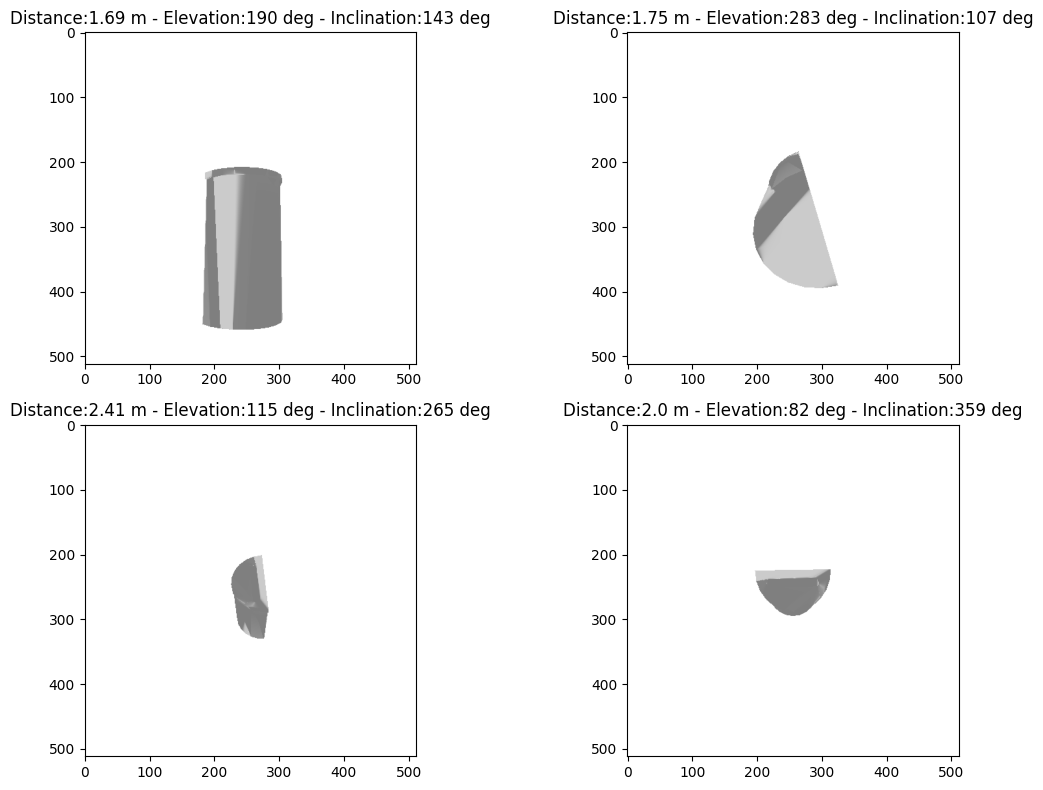

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images_[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances_[i]} m - Elevation:{elevations_[i]} deg - Inclination:{angles_[i]} deg")

plt.tight_layout()
plt.show()

In [59]:
rendered_images_[0].shape

torch.Size([1, 512, 512, 4])

## 2D augmentation


In [33]:
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(1, 1)),
    transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5)
])

In [60]:
def augmentation2D(rendered_images):
  augmented_images = [] # array with augmented images

  for rendered_image in rendered_images_:
    augmented_image = augment_transform(rendered_image[0, ..., :4].permute(2, 0, 1))
    augmented_images.append(augmented_image)

  return augmented_images

In [61]:
augmented_images = augmentation2D(rendered_images_)

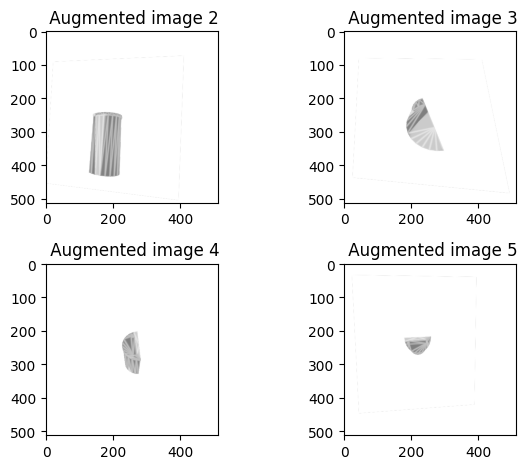

In [62]:
plt.subplot(2, 2, 1)

i  = 0
for augmented_image in augmented_images:
  plt.subplot(2, 2, i + 1)
  i += 1
  plt.imshow(augmented_image.cpu().permute(1, 2, 0))  # Convert back to (H, W, C) for display
  plt.title(f" Augmented image {i + 1}")

plt.tight_layout()
plt.show()

In [63]:
augmented_image[0].shape

torch.Size([512, 512])

## Getting the images for the 2D guidance


In [36]:
guid_mesh_idx = 3
guid_mesh_path = meshes_paths[guid_mesh_idx]
guid_mesh = meshes[guid_mesh_idx]

mesh_fig = mesh_visualization(guid_mesh_path)
mesh_fig.show()

In [37]:
guid_distances, guid_elevations, guid_angles, guid_rendered_images = rendered_shape(guid_mesh,device,items=4)

[LOG] Computing render for distance 2.35, elevation 349, angle 0
[LOG] Computing render for distance 1.39, elevation 48, angle 267
[LOG] Computing render for distance 2.88, elevation 142, angle 333
[LOG] Computing render for distance 2.24, elevation 154, angle 162


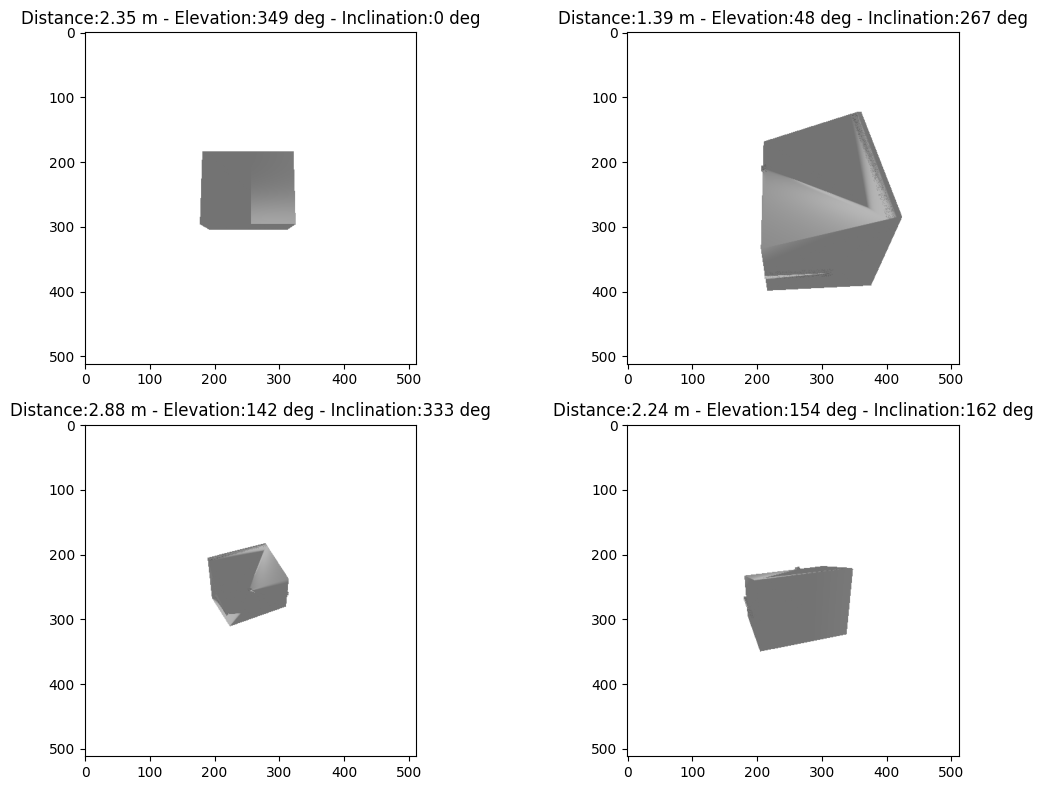

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(guid_rendered_images[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{guid_distances[i]} m - Elevation:{guid_elevations[i]} deg - Inclination:{guid_angles[i]} deg")

plt.tight_layout()
plt.show()

In [57]:
guid_rendered_images[0].shape

torch.Size([1, 512, 512, 4])

# Training

In [99]:
optimizer = optim.Adam(nsf.parameters(), lr=0.001)

criterion = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()

In [ ]:
num_epochs = 1000

for epoch in range(num_epochs):
  loss = 0
  optimizer.zero_grad()
  predicted_displacement = nsf(sample_mesh_verts)
  update_mesh(sample_mesh, predicted_displacement)
  _, _, _, mesh_rendered_images = rendered_shape(sample_mesh,device,items=4)
  mesh_augmented_images = augmentation2D(mesh_rendered_images)
  for mesh_augmented_image in mesh_augmented_images:
    mesh_augmented_image.requires_grad_(True)
    for guid_rendered_image in guid_rendered_images:
      guid_rendered_image = guid_rendered_image.squeeze(0)
      guid_rendered_image = guid_rendered_image.permute(2, 0, 1)
      guid_rendered_image.requires_grad_(True)
      loss += criterion(mesh_augmented_image, guid_rendered_image)
  loss.backward()
  optimizer.step()

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Full architecture

In [121]:
class FullNet(nn.Module):
  def __init__(self, sample_mesh):
    super(FullNet, self).__init__()

    self.sample_mesh = sample_mesh

    self.nsf = NeuralStyleField(
      verts_dim = global_var['verts_dim'],
      hidden_dim = global_var['hidden_dim'],
      depth = global_var['emb_net_depth'],
      disp_dim = global_var['disp_dim'],
      disp_depth = global_var['disp_net_depth'],
      norm_ratio = global_var['norm_ratio'],
      debug = global_var['print_debug']
    ).to(device)

  def forward(self, x):
    predicted_displacement = self.nsf(x)

    update_mesh(sample_mesh, predicted_displacement)
    _, _, _, mesh_rendered_images = rendered_shape(sample_mesh,device,items=4)
    augmented_images = augmentation2D(mesh_rendered_images)

    return augmented_images

In [138]:
num_epochs = 100
model = FullNet(sample_mesh)
optimizer = optim.Adam(nsf.parameters(), lr=0.0001)

criterion = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()

In [139]:
for epoch in range(num_epochs):

  mesh_augmented_images = model(sample_mesh_verts)

  total_loss = 0

  for mesh_augmented_image in mesh_augmented_images:
    mesh_augmented_image.requires_grad_(True)
    for guid_rendered_image in guid_rendered_images:
      guid_rendered_image = guid_rendered_image.squeeze(0)
      guid_rendered_image = guid_rendered_image.permute(2, 0, 1)
      guid_rendered_image.requires_grad_(True)
      loss = criterion(mesh_augmented_image, guid_rendered_image)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

----------
----------
----------
----------
----------
----------
Epoch 1/100, Loss: 2.1462876722216606
----------
----------
----------
----------
----------
----------
Epoch 2/100, Loss: 1.7066422179341316
----------
----------
----------
----------
----------
----------
Epoch 3/100, Loss: 2.180468626320362
----------
----------
----------
----------
----------
----------
Epoch 4/100, Loss: 1.494972730986774
----------
----------
----------
----------
----------
----------
Epoch 5/100, Loss: 2.388920024037361
----------
----------
----------
----------
----------
----------
Epoch 6/100, Loss: 1.8375719441100955
----------
----------
----------
----------
----------
----------
Epoch 7/100, Loss: 1.7936500012874603
----------
----------
----------
----------
----------
----------
Epoch 8/100, Loss: 1.6736060734838247
----------
----------
----------
----------
----------
----------
Epoch 9/100, Loss: 2.027427703142166
----------
----------
----------
----------
----------
----------
Ep